# Purpose of the Code

The goal of this notebook is to extract EMG signals recorded using Myo armband system, process the raw data, extract meaningful features, and store the resulting information in a structured DataFrame format.

## Environment Setup

In [1]:
# pip install libemg  # Required only if you have never installed the libemg package
# pip install --upgrade paramiko cryptography  # Needed during first-time installation of libemg to resolve dependencies

In [2]:
import os
import pandas as pd
import numpy as np
import sys
sys.path.append('../../lib')
from import_emg_file import import_data_from_myo
from myo_utils import myo_dataframe_edit, myo_extract_muscle_emg
from emg_utils import plot_emg_signal, emg_filters, extract_emg_windows, extract_emg_features
from features_utils import combine_multiple_features_lists, detect_segments, assign_emg_labels

In [3]:
# Parameters
intensity = "medium"  # Intensity of the task: "light", "medium", or "heavy"
channel_numbers = [1, 2, 3, 4, 5, 6, 7, 8]  # Possible channels: from 1 to 8
channel_ref_number = 6 
channel_names = [f"channel_{num}" for num in channel_numbers] # Create channel of interest names
channel_ref = f"channel_{channel_ref_number}" # Reference channel for true label assignment
w_d = 0.2  # Window duration in seconds for feature extraction
ov = 0.5  # Overlap percentage between windows (e.g., 0.5 = 50%)
n_lifts = 3  # Number of lifts
fs = 200 # Frequency of Myo armband
fs_list = []  # Initialize list to store sampling frequencies

# Feature lists
features_list_norm = ['MAV', 'WL', 'RMS', 'VAR', 'IAV', 'LD', 'SAMPEN', 'MPK', 'WAMP']  # Features on normalized signal
features_list_filt = ['ZC', 'SSC', 'KURT', 'SKEW']  # Features on filtered signal
features_list_freq = ['MNF', 'MNP', 'SM', 'ISD']  # Frequency-domain features

# Paths for input and output
input_folder = f'../../data/acquisitions/myo/05_26/{intensity}/'  # Input folder with raw data
output_folder = '../../data/extracted_features/myo/S01_05_26/features'  # Output folder to save extracted features
output_filename = f"features_{intensity}.csv"  # Name of the output CSV file
mvc = '../../data/mvc_values/myo/S01_05_26/combined_dataset.csv' # Name of the mvc dataset

# Loading Data Files

In [4]:
dataframes = import_data_from_myo(input_folder)  # Import raw data from Myo folder
dataframes = [myo_dataframe_edit(df) for df in dataframes]  # Format each imported dataframe

In [5]:
muscle_emg_raw, emg_time = myo_extract_muscle_emg(dataframes, channel_names, fs)  # Extract EMG signals and timestamps for the specified channels
# for channel in channel_names:
    # plot_emg_signal(muscle_emg_raw[channel][0], emg_time[0], title=f"{channel} EMG Raw Signal #1")  # Plot raw EMG signal

# EMG Signal Analysis

## Filtering, Rectification, Smoothing and Normalization

In [6]:
for time in emg_time:
    fs_list.append(fs)

In [7]:
muscle_emg_filtered, _, _, muscle_emg_normalized = emg_filters(muscle_emg_raw, emg_time, fs_list, channel_names, mvc)
# for channel in channel_names:
    # plot_emg_signal(muscle_emg_normalized[channel][0], emg_time[0], 
                    # title=f"{channel} EMG Normalized Signal #1", ylabel="EMG / MVC")  # Plot normalized EMG signal

## Windowing and Features Extraction

In [8]:
normalized_win, filtered_win, time_win = extract_emg_windows(
    muscle_emg_normalized, muscle_emg_filtered, emg_time, fs_list, w_d, ov)  # Extract windows with specified duration and overlap

In [9]:
# Features Extraction
time_features_norm = extract_emg_features(normalized_win, features_list_norm)  # Extract time-domain features from normalized EMG windows
time_features_filt = extract_emg_features(filtered_win, features_list_filt)  # Extract time-domain features from filtered EMG windows
freq_features_norm = extract_emg_features(normalized_win, features_list_freq)  # Extract frequency-domain features from normalized EMG windows 

In [10]:
dfs = combine_multiple_features_lists(time_features_norm, time_features_filt, freq_features_norm)  # Combine all feature lists into a single dataframe

## Label Assignment

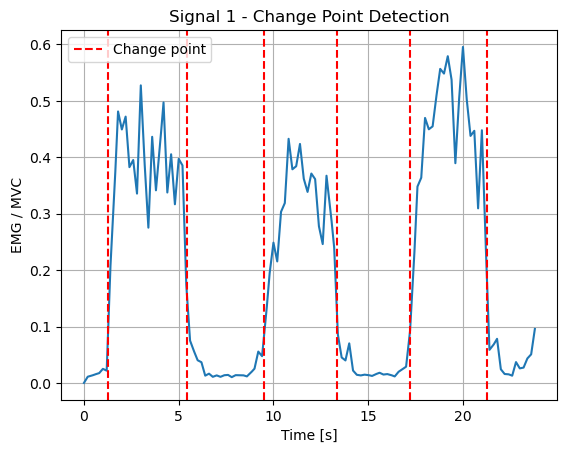

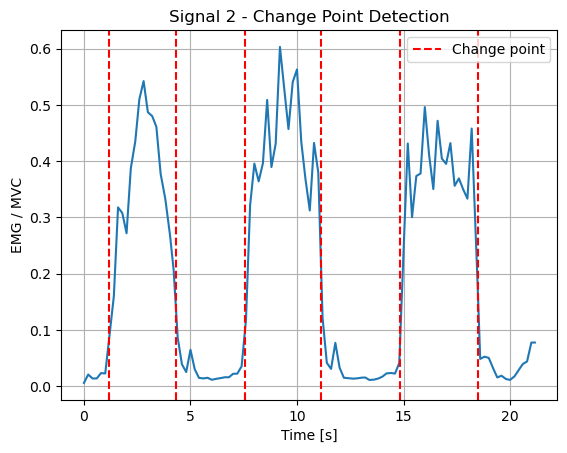

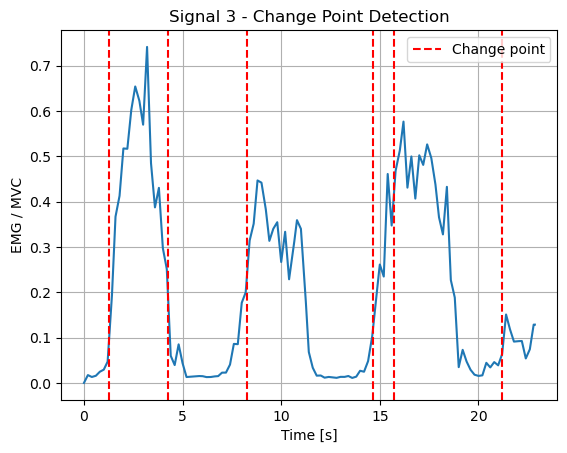

In [11]:
all_bkps_list = detect_segments(muscle_emg_normalized[channel_ref], emg_time, intensity, n_lifts, plot=True)  # Detect lifts segments

In [12]:
dfs['label'] = assign_emg_labels(all_bkps_list, normalized_win[channel_ref], fs_list, w_d, ov, intensity)  # Assign activity labels

# Features Export

In [13]:
output_path = os.path.join(output_folder, output_filename)  # Create full path for output CSV file
dfs.to_csv(output_path, index=False)  # Save dataframe with features and labels to CSV